<a href="https://colab.research.google.com/github/pgeorgantopoulos/PINNs-Photogrammetry/blob/main/pinn_min_example_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN minimal example <i>(Data-driven solution of p.d.e)<i>

*This is a classical regression problem.*

Given the dynamics
$$
\dot{\pmb x} = \pmb f(\pmb x,t), \quad t \in [0,T]
$$

and a set of measurements $\{\pmb x_i,t_i\}_{i=0}^{N-1}$ (collocation points)

we seek to approximate $\pmb x(t)$ at any point $t \in [0,T]$.

e.g. Dynamics of Ballistic Trajectory (BT)
\begin{align}
    \dot{\pmb x} &= \pmb v(t)\\
    \dot{\pmb v} &=
    \begin{bmatrix}
        0\\
        -9.81
    \end{bmatrix}=\lambda
\end{align}

with the ground truth solution being

\begin{align}
    \pmb x(t) = \pmb x_0 + \pmb v_0t - \dfrac{1}{2}\lambda t^2
\end{align}

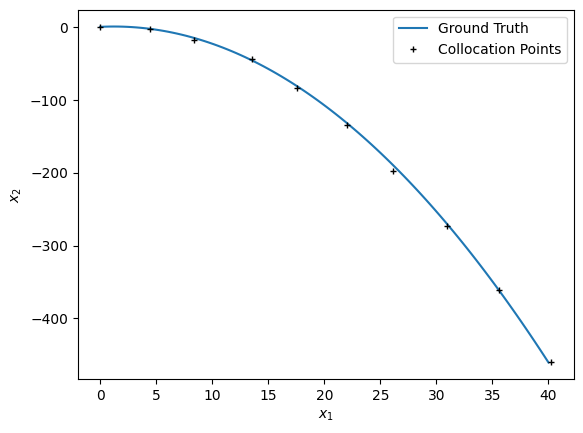

In [1]:
import numpy as np
# import matplotlib
# matplotlib.use('qtagg')

%matplotlib inline
import matplotlib.pyplot as plt
import torch

""" KNOWN """

def dxdtdt(t): # second derivative of x wrt t
    return torch.tensor([[0], [-9.81]])


""" UNKNOWN """

# unknown x(t)
def x(t): # noisy measurements
    t = t.view(-1,1)
    g = torch.tensor([0.0, -9.81]) # acceleration in x,y
    x0 = torch.tensor([0, 0]) # initial velocities in x,y
    dxdt0 = torch.tensor([4, 3])
    return (dxdt0*t + 0.5*g*t**2).T

T = 10
# Collocation points
t_c = torch.Tensor(np.linspace(0, T, 10))
x_c = x(t_c) + torch.randn(2,len(t_c))*0.3

# Plots
t = torch.Tensor(np.linspace(0, T, 100))
x_gt = x(t)
plt.figure()
plt.plot(x_gt[0,:], x_gt[1,:], label='Ground Truth')
plt.plot(x_c[0,:].detach().numpy(), x_c[1,:].detach().numpy(), 'k+', markersize=5, label='Collocation Points')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.xlim([0,10])
plt.legend()
plt.show()

## IVP solvers

Use only initial conditions $ \pmb x(0) = \pmb x_0 $ and $ \pmb v(0) = \pmb v_0 $.

with $\pmb x(t)$ approximation e.g. for Euler

$$ \pmb x(t_n) = \pmb x(t_{n-1}) + \pmb f(\pmb x(t_{n-1}), t_{n-1}) (t_n - t_{n-1})$$

**Note**: To translate this into regression problem we must incorporate a rule of update for the solution at any point based on a loss function.

For the BT example, to use Euler we first have to reduce the system to the $1^{st}$ order

\begin{align}
    \dot{\pmb y} =
    \begin{bmatrix}
        \dot{\pmb x}\\
        \dot{\pmb v}
    \end{bmatrix} =
    \begin{bmatrix}
        0\\
        -9.81
    \end{bmatrix}
\end{align}

and apply

\begin{align}
        \pmb y_{n} &= \pmb y_{n-1} +
        \begin{bmatrix}
            0\\
            -9.81
        \end{bmatrix}_{n}dt_n
\end{align}
center or
\begin{align}
        \pmb x_{n} &= \pmb x_{n-1} + \pmb v_{n}dt_n \\
        \pmb v_{n} &= \pmb v_{n-1} +
        \begin{bmatrix}
            0\\
            -9.81
        \end{bmatrix}_{n}dt_n
\end{align}


/tmp/ipykernel_6426/2046956349.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  x0 = torch.tensor([0., 0.]).T


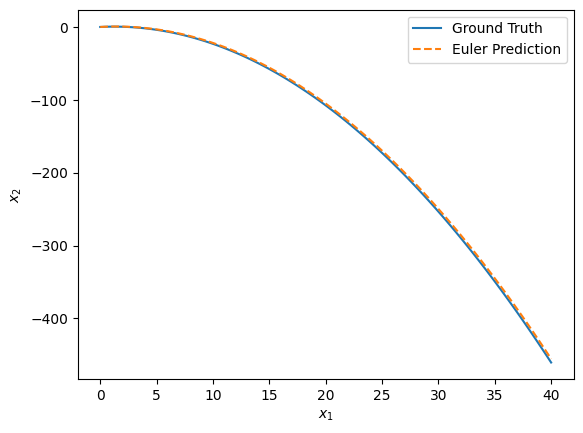

In [2]:
t = torch.Tensor(np.linspace(0, T, 100))
dt = t[1] - t[0]

# Initial conditions
x0 = torch.tensor([0., 0.]).T
v0 = torch.tensor([4., 3.]).T
s0 = torch.cat((x0,v0),dim=0)

# Euler
s_pred = torch.zeros(s0.shape[0],len(t))
s_pred[:,[0]] = s0.view(-1,1)

for i in range(1,len(t)):
    s_pred[:,[i]] = s_pred[:,[i-1]] + torch.cat((s_pred[2:4,[i-1]], dxdtdt(t[i-1])),dim=0) * dt

# Plots
plt.plot(x_gt[0,:], x_gt[1,:], label='Ground Truth')
plt.plot(s_pred[0,:], s_pred[1,:],'--', label='Euler Prediction')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.xlim([0,10])
plt.legend()

## PINN approximation

Let $g(t;\theta)$ aproximate $x(t)$.

$$ g(t_i; \theta) \rightarrow x_i $$

$$ \underset{\theta}{\min} \underset{L_1}{\underbrace{\dfrac{1}{|S_1|}\sum_{S_1} ||g(t_i) - x_i||^2}} + \underset{L_2}{\underbrace{\sum_{S_2} ||\dfrac{dg}{dt}|_{t_i} - f(x_i,t_i)||^2}} $$

$L_2$ imposes a classical smoothness constraint, since we have higher order information for the given measurements, that is the derivative of the solution $f(x,t)$.

Initialized nn with parameters:
<bound method Module.parameters of model(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5, out_features=2, bias=True)
  )
)>
Epoch: 0, Loss1: 106950.796875, Loss2: 0.0
Epoch: 200, Loss1: 62486.4296875, Loss2: 0.0
Epoch: 400, Loss1: 37177.88671875, Loss2: 0.0
Epoch: 600, Loss1: 22269.04296875, Loss2: 0.0
Epoch: 800, Loss1: 13438.849609375, Loss2: 0.0
Epoch: 1000, Loss1: 8009.908203125, Loss2: 0.0
Epoch: 1200, Loss1: 4812.759765625, Loss2: 0.0
Epoch: 1400, Loss1: 3005.96923828125, Loss2: 0.0
Epoch: 1600, Loss1: 1758.8782958984375, Loss2: 0.0
Epoch: 1800, Loss1: 915.5343017578125, Loss2: 0.0


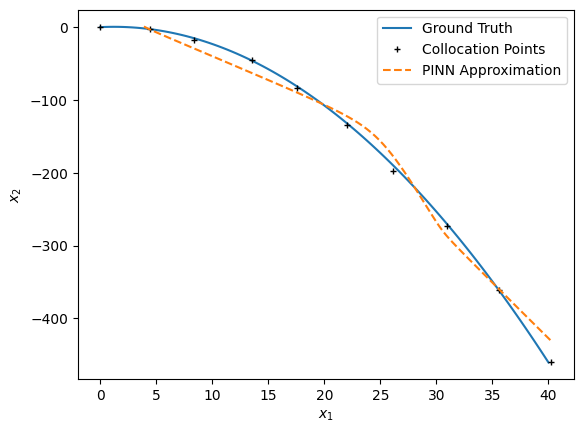

In [3]:
import torch.nn as nn

# Approximating function of x
class model(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(nn.Linear(1,5),
                                    nn.Tanh(),
                                    nn.Linear(5,2),
                                    # nn.Tanh()     # if added, it breaks results
                                    ).float()
        self.NUM_EPOCHS = 2000
        self.LR = 0.1
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.LR)

        print('Initialized nn with parameters:')
        print(self.parameters)

    def forward(self,t):
        return self.net(t.view(-1,1)).T

g = model()

loss_fn = nn.MSELoss()
t_c.requires_grad = True

for epoch in range(g.NUM_EPOCHS):
    g.optimizer.zero_grad()

    loss = 0.0
    for i, t_c_i in enumerate(t_c):
        x_i = g(t_c_i)
        dxdt_i = torch.zeros(2,1)
        dxdtdt_i = torch.zeros(2,1)
        dxdt_i[0] = torch.autograd.grad(x_i[0].squeeze(), t_c_i, create_graph=True)[0]
        dxdt_i[1] = torch.autograd.grad(x_i[1].squeeze(), t_c_i, create_graph=True)[0]
        dxdtdt_i[0] = torch.autograd.grad(dxdt_i[0].squeeze(), t_c_i, create_graph=True)[0]
        dxdtdt_i[1] = torch.autograd.grad(dxdt_i[1].squeeze(), t_c_i, create_graph=True)[0]
        loss1 = loss_fn(x_i, x_c[:,[i]]) 
        loss2 = loss_fn(dxdtdt_i, dxdtdt(t_c_i)) * 0
        loss += (loss1 + loss2)/len(t_c)
        # loss += (loss_fn(x_i, x_c[:,[i]]) + loss_fn(dxdtdt_i, dxdtdt(t_c_i)))/len(t_c)

    loss.backward()
    g.optimizer.step()

    if epoch % (g.NUM_EPOCHS*.1) == 0:
        print(f'Epoch: {epoch}, Loss1: {loss1.item()}, Loss2: {loss2.item()}')

# Plots
plt.figure()
x_pred = g(t).detach().numpy()
plt.plot(x_gt[0,:], x_gt[1,:], label='Ground Truth')
plt.plot(x_c[0,:].detach().numpy(), x_c[1,:].detach().numpy(), 'k+', markersize=5, label='Collocation Points')
plt.plot(x_pred[0,:], x_pred[1,:],'--', label='PINN Approximation')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.xlim([-2,10])
plt.legend()
plt.show()

# Kalman filter

Fist, use $1^{s}t$ order reduced model and let

\begin{align}
    \pmb s =
    \begin{bmatrix}
        \pmb x \\
        \pmb v
    \end{bmatrix}
\end{align}
and
\begin{align}
    s_{n|n-1} &= A_n\ s_{n-1|n-1} + B_n u_n +  w_n \\
    x_n &= C_n\ s_n + v_n
\end{align}

For each measurement $x_n$ there is a state-correction step. State correction requires  covariance estimates for state and residual.

State
$$ s_{n|n-1} = A_n s_{n-1|n-1} + B_n u_n + w_n $$
$$ S_{n|n-1} = A_n S_{n-1|n-1} A_n^T + W_n $$
Residual
$$ r_n = x_n - C_n s_{n|n-1} $$
$$ R_n = C_n S_{n|n-1} C_n^T + V_n $$
Corrections
$$ s_{n|n} = s_{n|n-1} + K_n r_n, \quad K_n = S_{n|n-1} C_n^T R_n^{-1} $$
$$ r_n = x_n - C_n s_n $$
$$ S_{n|n} = (I - K_n C_n) S_{n|n} $$

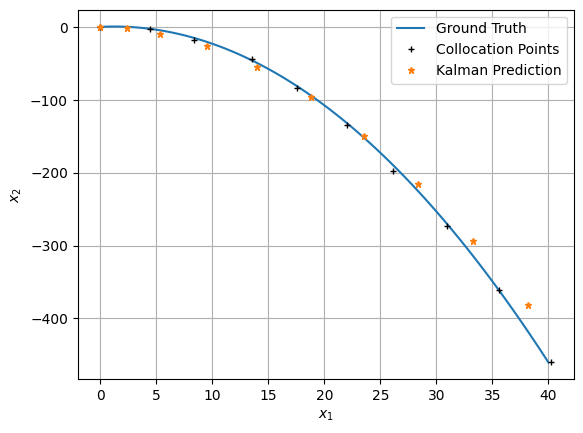

In [10]:
# System setting
import matplotlib

"""
State vector:
    
    s = [x1 x2 v1 v2]

State model (assumed constant accesleration):

    x1 = x1 + v1 * dt + 1/2 * a1 * dt^2
    x2 = x2 + v2 * dt + 1/2 * a2 * dt^2
    v1 = v1 + a1 * dt
    v2 = v2 + a2 * dt

Input vector:
    u = [a1 a2] = [0, -9.81]
"""

dt = t[1] - t[0]

A = torch.tensor([  [1, 0, dt,0], 
                    [0, 1, 0, dt],
                    [0, 0, 1, 0], 
                    [0, 0, 0, 1],
                    ],dtype=torch.float32)

B = torch.tensor([  [0.5*dt**2, 0,         0,  0],
                    [0,         0.5*dt**2, 0,  0],
                    [0,         0,         dt, 0],
                    [0,         0,         0,  dt]
                    ],dtype=torch.float32)

u = torch.tensor(   [0, -9.81, 0, -9.81],
                    dtype=torch.float32).view(-1,1)

## Measurement model
C = torch.tensor([  [1, 0, 0, 0],
                    [0, 1, 0, 0]
                    ],dtype=torch.float32)

# Initial conditions
s = torch.zeros((A.shape[0],1))

# Parameters
S = torch.eye(s.shape[0]) # state covariance
W = torch.eye(s.shape[0]) * 0.01 # state noise covariance
V = torch.eye(x_c.shape[0]) * 0.09 # measurement noise covariance

x_pred = torch.zeros_like(x_c)

for i in range(x_c.shape[1]):

    s = A @ s + B @ u
    S = A @ S @ A.T + W

    R = C @ S @ C.T + V
    K = S @ C.T @ R.inverse()
    r = x_c[:,[i]] - C @ s
    s = s + K @ r
    S = (torch.eye(s.shape[0]) - K @ C) @ S
    x_pred[:,[i]] = (C @ s)

plt.plot(x_gt[0,:], x_gt[1,:], label='Ground Truth')
plt.plot(x_c[0,:].detach().numpy(), x_c[1,:].detach().numpy(), 'k+', markersize=5, label='Collocation Points')
plt.plot(x_pred[0,:], x_pred[1,:], '*', markersize=5, label='Kalman Prediction')
plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.xlim([-1,5])
# plt.ylim([-10,2])
plt.legend()